# Luttinger Kohn Model of Particle in Box 
## Study of anisotropy of g-tensor

This Notebook studies the effect of asymmetric in-plane confinement on the g-tensor components in Germaium Heterostructures

### Model Setup

Loading relevant modules and setting up jupyter

In [1]:
try:
    import nqcpfem
except ModuleNotFoundError as err:
    import sys
        # put path to nqcpfem module here   
    src_path = '/mnt/c/Users/olisc/NQCP/NQCP_FEM/'
    sys.path.append(src_path)
    import nqcpfem
import sympy
sympy.init_printing(use_latex='mathjax')
import IPython.display as disp
from matplotlib import pyplot as plt
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)


Bare Luttinger-Kohn Hamiltonian

⎡ 2 ⎛           ⎛     2        2        2⎞                   2                
⎢h̅ ⋅⎝\gamma_{1}⋅⎝k_{x}  + k_{y}  + k_{z} ⎠ + \gamma_{2}⋅k_{x}  + \gamma_{2}⋅k
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                  2⋅m                        
⎢                                                                             
⎢                             2                                               
⎢             -√3⋅\gamma_{3}⋅h̅ ⋅(k_{x}⋅k_{z} + k_{z}⋅k_{x} + ⅈ⋅(k_{y}⋅k_{z} +
⎢             ────────────────────────────────────────────────────────────────
⎢                                                  2⋅m                        
⎢                                                                             
⎢            2 ⎛                2                   2                         
⎢       -√3⋅h̅ ⋅⎝\gamma_{2}⋅k_{x}  - \gamma_{2}⋅k_{y}  + ⅈ⋅\gamma_{3}⋅(k_{x}⋅k
⎢       ────────────────────────────────────────────

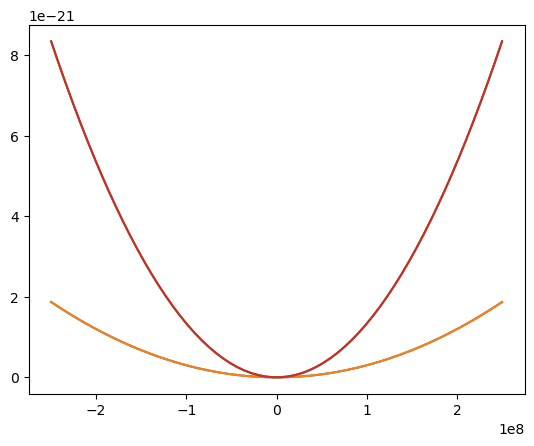

In [2]:
from nqcpfem.band_model import LuttingerKohnHamiltonian
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge') # sets coefficients to those of Winkler

# jupyter does not like \hbar so we have to change it to hbar when displaying the Hamiltonian
disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify())

# plot spectrum as well
spectrum = bm.spectrum((-2.5e8,2.5e8),(1,0),64)
_=plt.plot(*spectrum)

adding z-confinement can be done using a simple command. Under the hood, it replaces $k_z$ and $z$ with their matrix representations with respect to the basis of box-modes or SHO modes (depdending on the confinement type)

⎡ 2 ⎛   2 ⎛                2                   2                   2          
⎢h̅ ⋅⎝l_z ⋅⎝\gamma_{1}⋅k_{x}  + \gamma_{1}⋅k_{y}  + \gamma_{2}⋅k_{x}  + \gamma
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                               2             
⎢                                                          2⋅l_z ⋅m           
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                             0               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢               2 ⎛                  2              

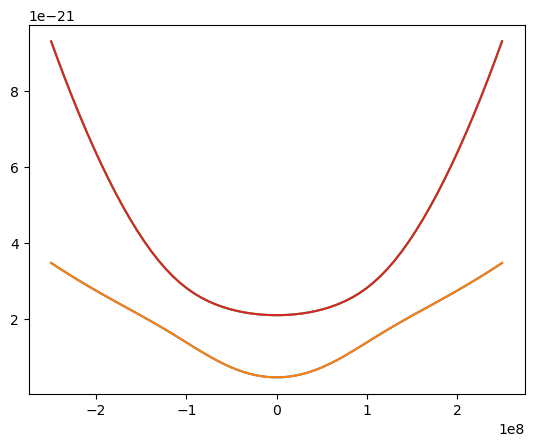

In [3]:
bm.add_z_confinement(nz_modes=1,z_confinement_type='box',lz=25e-9)


disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify()[:,:,0,0])
spectrum = bm.spectrum(k_range=(-2.5e8,2.5e8),k_direction=(1,0),n_points=64)
_=plt.plot(*spectrum)

### Envelope Function Model
We now have a hamiltonian which we wish to solve numerically using FEM. The first thing we have to do is to assure that 
the $k$-operators are ordered correctly (this is only relevant if there are expressions in the hamiltonian which involve both position and momentum)


In [4]:
bm.fix_k_arrangement('FEM')


We first define the domain (a rectangle)

In [5]:
from nqcpfem.envelope_function import RectangleDomain
domain = RectangleDomain(Lx=1e-7,Ly=1e-7,Lz=0) # 100 x 100 nm. Lz unimportant since our model is 2D
domain.resolution = [100,100] # resolution for the FEM model. Number of points to partition the x and y directions into

Next we define the solver which will compute the eigenvalues and energies of our Hamiltonian

In [6]:
from nqcpfem.solvers import PETScSolver

# we want the 10 eigenstates which are closest to 0, so we look for eigenstates of small magnitude (SM) relative to sigma=0
solver = PETScSolver(k=10,which='SM',sigma=0)

#### FEM
We can now define the FEM model given the Hamiltonian to solve, the domain of interest, which boundary condition to impose on the edges of the domain, and which function class to use in the FEM modeling:

In [7]:
from nqcpfem.fenics import FEniCsModel
fem_model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1)) 

solving the model is now straight-forward

In [8]:
eigenvals,eigenvecs = solver.solve(fem_model)

# print eigenvalues in meV
eigenvals*nqcpfem.UNIT_CONVENTION['J to eV']*1000 

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_21fb77272a085826878b4ce75c0a6c84330862cc' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_21fb77272a085826878b4ce75c0a6c84330862cc.c -o ./libffcx_forms_21fb77272a085826878b4ce75c0a6c84330862cc.o -O2 -g0
INFO

array([4.23758606, 4.23758606, 5.93796346, 5.93796346, 6.11451128,
       6.11451128, 7.50269   , 7.50269   , 8.51642392, 8.51642392])

##### Plotting the Eigenstates
We can plot the probability density function $\| \psi(x)\|^2$ on the domain

In [9]:
from nqcpfem.plotting import plot_eigenvector
plot_eigenvector(eigenvecs[0],fem_model)

INFO:root:awaiting runner setup
INFO:root:awaiting site startup
INFO:root:awaiting running future


Widget(value="<iframe src='http://localhost:39577/index.html?ui=P_0x7f6212aa20e0_0&reconnect=auto' style='widt…

In [10]:
plot_eigenvector(eigenvecs[2],fem_model)

Widget(value="<iframe src='http://localhost:39577/index.html?ui=P_0x7f6214828a00_1&reconnect=auto' style='widt…

In [11]:

plot_eigenvector(eigenvecs[6],fem_model)

Widget(value="<iframe src='http://localhost:39577/index.html?ui=P_0x7f6214892830_2&reconnect=auto' style='widt…

## G-matrix
We can compute the G-matrix from the ground state Kramer's pair of of the envelope model. 
First we need to add a magnetic field term to the Hamiltonian

In [12]:
# not specifying any values of B since we do not need it for computing the g-matrix. 
# We still have to add a Zeeman term though because we need ot know which matrix elements are linear in B
bm.add_zeeman_term() 
disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify()[:,:,0,0])

⎡             2                                                    2    2 ⎛   
⎢3⋅\mu_{B}⋅l_z ⋅m⋅(4⋅κ⋅(B_{z})_{00}(x) + 9⋅q⋅(B_{z})_{00}(x)) + 2⋅h̅ ⋅l_z ⋅⎝\g
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                              √3⋅\mu_{B}⋅(4⋅κ⋅(B_{x})_{00}(x)
⎢                                              ───────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                  2

Note that the B-field is labeled as $(B_{x})_{00}(x)$ because the B-field is projected down onto the lowest z-mode. From this we can compute the G-matrix. The following code automatically determines which terms in the above Hamiltonian are linear in B and computes the expectation values of these terms wrt the ground state kramers pair. 

In [13]:
from nqcpfem.g_matrix import GMatrix
gmat = GMatrix(fem_model,solver) # the solver is needed to compute the Kramer's pair

matrix = gmat.matrix()
np.linalg.svd(matrix)

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_9129599523af0e508f5dcae07000288980f109be' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_9129599523af0e508f5dcae07000288980f109be.c -o ./libffcx_forms_9129599523af0e508f5dcae07000288980f109be.o -O2 -g0
INFO

SVDResult(U=array([[ 0.9999392 ,  0.01025114,  0.00406347],
       [ 0.01015834, -0.71296693, -0.70112407],
       [ 0.0042902 , -0.70112272,  0.71302772]]), S=array([21.19027259,  0.14013198,  0.13857807]), Vh=array([[ 3.26713524e-15,  9.21189952e-15,  1.00000000e+00],
       [-7.07106781e-01, -7.07106781e-01,  8.82401010e-15],
       [ 7.07106781e-01, -7.07106781e-01,  4.20358314e-15]]))

### G-matrix as function of Box shape
Next we want to study how the G-matrix changes when changing the shape of the confinement box (which in our case is modeled by domain and its boundaries). We will fix $L_y = 100nm$ and vary $L_x \in [50nm,200nm]$. 


In [14]:
Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,64)*1e-9 # 50 - 200 nm 
model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
gmat = GMatrix(model,solver)
def model_evaluation(lx):
    dom = RectangleDomain(Lx=lx,Ly=Ly,Lz=0)
    dom.resolution = [300,300]
    gmat.envelope_model.domain = dom # just update the relevant parameter
    return gmat.matrix()

In order to save the computed results during the computation we use a ParameterSearch to evaluate the `model_evaluation` function at the
different values of `lx` and save the resulting g-matrix 

In [15]:
from nqcpfem.parameter_search import ParameterSearch
save_file = '100_fixed_y_gmat.save'

# this code just loads any saved files if they exists or creates a new ParameterSearch if it doesn't exists
search  = None 
if os.path.exists(save_file):
    try:
        search = ParameterSearch.load(save_file)
    except Exception as err:
        print(err)

if search is None:
    search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=model_evaluation,save_file=save_file)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [16]:
search.run(save_results=True,skip_errors=False)

From the computed G-matrices we can determine the singular-values and plot them as a function of $L_x$

Text(0.5, 1.0, '$L_{y} = 100$nm')

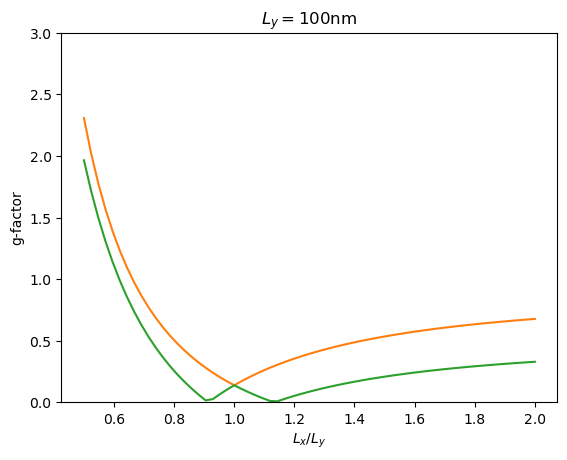

In [17]:
singular_values = np.stack([np.linalg.svd(a)[1] for a in search.results],axis=0)
plt.plot(Lx_values/Ly,singular_values)

plt.ylim(0,3) # we only care about in-plane ones 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm')

### Actually adding B-field
In order to check our result, we add an actual B-field and check that the energy splitting of the ground state Kramer's pair is consistent with the singular values of the g-matrix. We will only look at the case where $\vec{B} = B_x = 0.5 T$

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                      ⎡⎡                                     
⎢                                      ⎢⎢√3⋅\mu_{B}⋅κ⋅B_{x}(x) + √3⋅ⅈ⋅\mu_{B}⋅
⎢                                      ⎣⎣                                     
⎢                                                                             
⎢                                                                             
⎢                              ⎡⎡                 2 

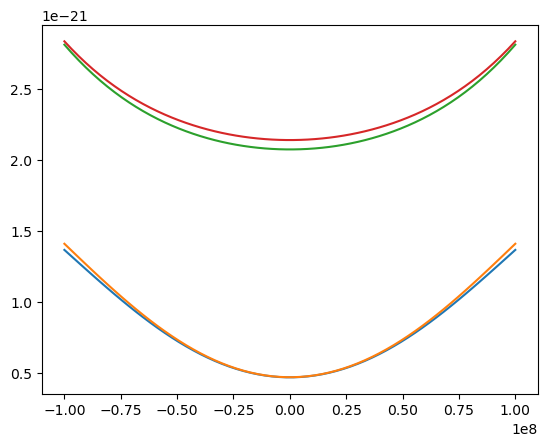

In [18]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
bm.add_zeeman_term(B=[0.5,0,0])

# NB the FEniCsModel assures that the k-ordering is correcty (but warns the user that it does this)
model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1)) 

_ = plt.plot(*bm.spectrum((-1e8,1e8),(1,0),64))
bm.post_processed_array().subs('\hbar','hbar')

In [19]:
Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,32)*1e-9 # 50 - 200 nm 


def model_evaluation(lx):
    dom = RectangleDomain(Lx=lx,Ly=Ly,Lz=0)
    dom.resolution = [100,100]
    model.domain = dom 
    return solver.solve(model) 
save_file = '100_bx_fix_y.save'

search_b  = None 
if os.path.exists(save_file):
    try:
        search_b = ParameterSearch.load(save_file)
    except Exception as err:
        print(err)

if search_b is None:
    search_b = ParameterSearch(parameter_sets = Lx_values,evaluation_function=model_evaluation,save_file=save_file)


In [20]:
search_b.run(save_results=True,skip_errors=False)

From the saved eigenvalues and eigenvectors we can determine the lowest energy Kramers pair and compute the energy splitting of them.
The following function does exactly that by takin the lowest energy state $\psi$ and finds the next state that looks the most like the spin-flipped version of $\psi$.

Text(0.5, 1.0, '$L_y = 100$nm, $B=B_{x} = 0.5T$')

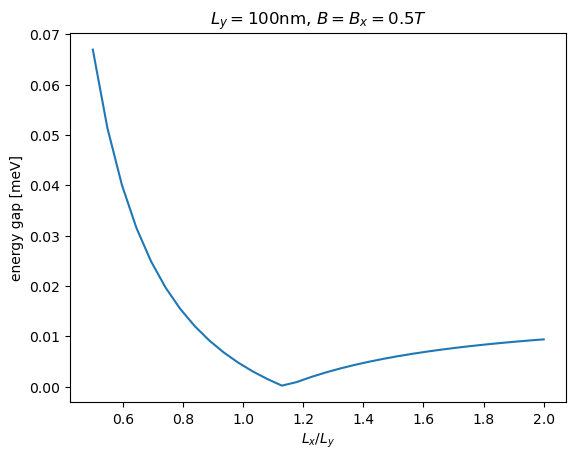

In [21]:
logging.getLogger().setLevel(logging.WARN)
from nqcpfem.spin_gap import find_spin_gap 
energy_diff = [find_spin_gap(s,model)[0] for s in search_b.results]



# plot the energy difference 
plt.plot(Lx_values/Ly,np.array(energy_diff)*nqcpfem.UNIT_CONVENTION['J to eV']*1000)
plt.ylabel('energy gap [meV]')
plt.xlabel('$L_x/L_y$')
plt.title(r'$L_y = 100$nm, $B=B_{x} = 0.5T$')

### Comparing with Simple Box-Mode computation
We can compare the FEM-computed result of the g-tensor with the same computaton using eigenstates of a particle in a box as our basis. 
The setup is exaclty the same:
- Define band model
- Define domain
- Define envelope-function model
- Define solver and use it to solve the model

In [22]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
bm.add_zeeman_term(B=[0.5,0,0])

from nqcpfem.solvers import ScipySolver
solver = ScipySolver(k=10)

from nqcpfem.box_modes import BoxEFM

box_model = BoxEFM(bm,domain,nx=1,ny=1) # just one mode in each direction

box_gmat = GMatrix(box_model,solver)

Note that we for this use the ScipySolver, which uses scipy instead of PETSc fror computing eigenvalues as this can handle dense matrices (which is what the BoxEFM model makes)
As before we construct a ParameterSearch for saving the results.

In [23]:

def box_model_eval(lx):
    domain = RectangleDomain(Lx=lx,Ly=Ly,Lz=0)
    box_gmat.envelope_model.domain = domain
    return gmat.matrix()

box_save = 'box_modes_1_1.save'

box_search  = None 
if os.path.exists(box_save):
    try:
        box_search = ParameterSearch.load(box_save)
    except Exception as err:
        print(err)

if box_search is None:
    box_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=box_model_eval,save_file=box_save)


In [24]:
box_search.run(save_results=True,skip_errors=False)

Text(0.5, 1.0, '$L_{y} = 100$nm (Box_modes)')

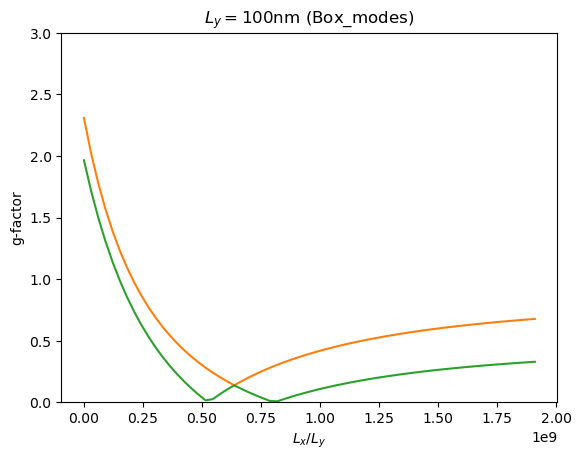

In [25]:
Lx_values = np.linspace(50e-9,200-9,64)
singular_values = np.stack([np.linalg.svd(a)[1] for a in search.results],axis=0)
plt.plot(Lx_values/Ly,singular_values)

plt.ylim(0,3) 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm (Box_modes)')

## Adding SHO potential
We now ad in-plane SHO potentials to show that the g-matrix dependency on the anisotropy of the in-plane wave-function is not just a result of the specific box potential.

The model is established in the same fashion as above, but with added potential.
We define the domain large enough such that the wave-function is almost zero the boundary due to the confinement potential.
We also keep the domain constant for this, because then, every time we change $\omega_x$ we can use the existing JIT-compiled builder for the array.

In [26]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
bm.add_zeeman_term(B=[0,0,0])

x,y,z = bm.position_symbols
omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
m = sympy.symbols('m')

V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

bm.add_potential(V)

domain = RectangleDomain(Lx=400e-9,Ly=200e-9,Lz=0) 
domain.resolution = [200,100]
fem_model = FEniCsModel(bm,domain,0,('CG',1))


The characterisitc length of a SHO is determine as the solution $\hbar^2 /(2m L^2) = \hbar \omega$: $L = \sqrt{\hbar / (2m \omega)}$
we fix $\omega_x$ such that $L = 10nm$

In [27]:

bm.material_spec('Ge')
omega_y_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(Ly/10)**2)

fem_model.band_model.parameter_dict[omega_y] = omega_y_val

solver = PETScSolver(k=10,which='SM',sigma=0)

#### Verifying that the shape is correct

In [28]:
#sho_gmat.envelope_model.band_model.parameter_dict[omega_x] = omega_y_val
omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(200e-9/10)**2)
fem_model.band_model.parameter_dict[omega_x] = omega_x_val
evals,evecs = solver.solve(fem_model) 

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_57bbfddbb90cfe6bdbdd7cf254fc4aa8ca7643a7' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_57bbfddbb90cfe6bdbdd7cf254fc4aa8ca7643a7.c -o ./libffcx_forms_57bbfddbb90cfe6bdbdd7cf254fc4aa8ca7643a7.o -O2 -g0
INFO

In [29]:
bm.post_processed_array().subs('\hbar','hbar')

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                           ⎡⎡                
⎢                                                           ⎢⎢√3⋅\mu_{B}⋅κ⋅B_{
⎢                                                           ⎣⎣                
⎢                                                                             
⎢                                                                             
⎢                                                   

In [30]:
pl=plot_eigenvector(evecs[0]*0.2,fem_model,scaling=True,return_plot=True)
pl.show_axes()
pl.show()

Widget(value="<iframe src='http://localhost:39577/index.html?ui=P_0x7f61bd998160_3&reconnect=auto' style='widt…

In [31]:
sho_gmat = GMatrix(fem_model,solver)
sho_gmat.envelope_model.band_model.parameter_dict[omega_y]


def sho_eval_func(lx):
    omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    sho_gmat.envelope_model.band_model.parameter_dict[omega_x] = omega_x_val
    return sho_gmat.matrix()

In [32]:
sho_save = 'sho_fem.save'

Lx_values = np.linspace(50e-9,200e-9,64)
sho_search  = None 
if os.path.exists(sho_save):
    try:
        sho_search = ParameterSearch.load(sho_save)
    except Exception as err:
        print(err)
#sho_search = None
if sho_search is None:
    sho_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=sho_eval_func,save_file=sho_save)


In [33]:
sho_search.run(True,True)

Text(0.5, 1.0, '$L_{y} = 100$nm (SHO)')

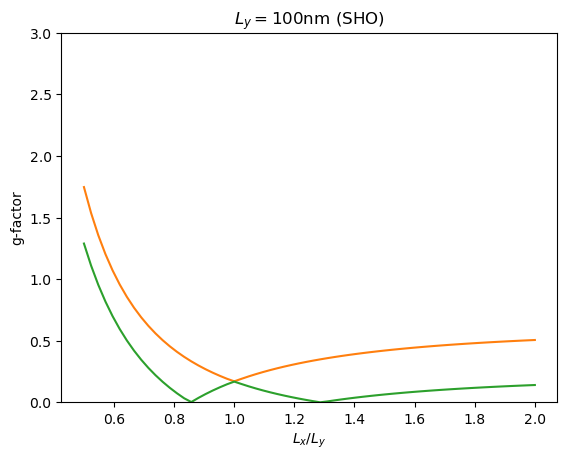

In [34]:
singular_values = np.stack([np.linalg.svd(a)[1] for a in sho_search.results],axis=0)
plt.plot(Lx_values/Ly,singular_values)

plt.ylim(0,3) 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm (SHO)')

# Orbital effects of magnetic fields on G-matrix
In this section, we study how magnetic fields alter the bound states in the system on an envelope-function level. To this extend, we not only have to add the Zeeman term as before, but also a vector potential A. Via SOI the A-field will manipulate the spin of the state. 

The G-matrix is capable of also determining the terms that are linear in $d A_i /d x_j $ and associate them with the relevant magnetic field  

In [35]:
bm  = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
bm.add_vector_potential().add_zeeman_term()
bm.fix_k_arrangement('FEM').material_spec('Ge')
bm.add_potential(V)
bm.post_processed_array().subs('\hbar','hbar')

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [36]:
Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,64)*1e-9 # 50 - 200 nm 
A_model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
A_gmat = GMatrix(A_model,solver)
omega_y_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(Ly/10)**2)

A_model.band_model.parameter_dict[omega_y] = omega_y_val
def A_eval_func(lx):
    omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    A_gmat.envelope_model.band_model.parameter_dict[omega_x] = omega_x_val
    return A_gmat.matrix()


In [37]:
A_save = 'A_fem.save'

Lx_values = np.linspace(50e-9,200e-9,64)
A_search  = None 
if os.path.exists(A_save):
    try:
        A_search = ParameterSearch.load(A_save)
    except Exception as err:
        print(err)

if A_search is None:
    A_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=A_eval_func,save_file=A_save)



In [38]:
A_search.run(True,False)

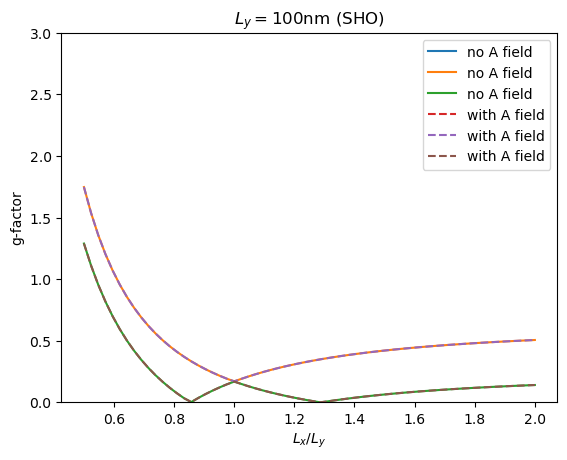

In [39]:
singular_values = np.stack([np.linalg.svd(a)[1] for a in sho_search.results],axis=0)
plt.plot(Lx_values/Ly,singular_values,label='no A field')

A_singular_values = np.stack([np.linalg.svd(a)[1] for a in A_search.results],axis=0)
plt.plot(Lx_values/Ly,A_singular_values,label='with A field',ls='--')

plt.ylim(0,3) 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm (SHO)')
plt.legend()

In [40]:
# Only a-field contribution
bm  = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
bm.add_vector_potential()
bm.fix_k_arrangement('FEM').material_spec('Ge')
bm.add_potential(V)
bm.post_processed_array().subs('\hbar','hbar')

Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,16)*1e-9 # 50 - 200 nm 
A_model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
A_gmat = GMatrix(A_model,solver)
omega_y_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(Ly/10)**2)

A_model.band_model.parameter_dict[omega_y] = omega_y_val
def A_eval_func(lx):
    omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    A_gmat.envelope_model.band_model.parameter_dict[omega_x] = omega_x_val
    return A_gmat.matrix()

A_no_B_save = 'A_no_B_fem.save'

Lx_values = np.linspace(50e-9,200e-9,64)
Ab_search  = None 
if os.path.exists(A_no_B_save):
    try:
        Ab_search = ParameterSearch.load(A_no_B_save)
    except Exception as err:
        print(err)

if Ab_search is None:
    Ab_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=A_eval_func,save_file=A_no_B_save)




In [41]:
Ab_search.run(True,True)

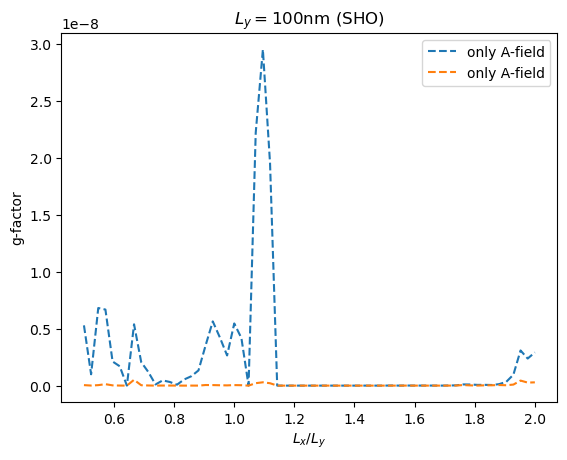

In [42]:
singular_values = np.stack([np.linalg.svd(a)[1] for a in sho_search.results],axis=0)
#plt.plot(Lx_values/Ly,singular_values,label='only B-field')

Ab_singular_values = np.stack([np.linalg.svd(a)[1] for a in Ab_search.results],axis=0)
plt.plot(Lx_values/Ly,Ab_singular_values[:,1:],label='only A-field',ls='--')

#plt.ylim(0,3) 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm (SHO)')
plt.legend()

Only the out-of-plane G-factor seems to change significantly:

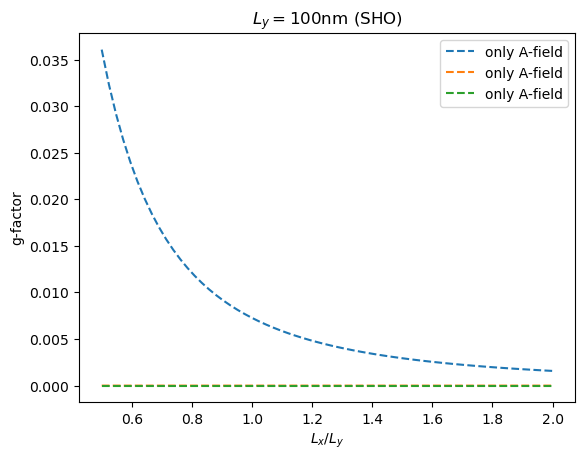

In [43]:
plt.plot(Lx_values/Ly,Ab_singular_values[:],label='only A-field',ls='--')

#plt.ylim(0,3) 
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm (SHO)')
plt.legend()

### Verifying with the actual energy
As before we verify the g-matrix computation by actually adding an A-field and see if we reproduce the g-matrix result.
The orbital effects seem to depend a lot on the magnitude of the B-field, so we will pick different values of the B-field as well, to also study the range validity of the g-matrix formalism wrt the strength of the B-field.

In [44]:
from nqcpfem.band_model import make_vector_field
bm = LuttingerKohnHamiltonian(spatial_dim=3).add_z_confinement(1,'box',25e-9).material_spec('Ge').fix_k_arrangement('FEM')
A_field = make_vector_field([5,0,0],bm.position_symbols)
print(A_field)
bm.add_vector_potential(vector_potential=A_field)



bm.add_potential(V)
bm.post_processed_array().subs('\hbar','hbar')


[0, -5*z/2, 5*y/2]


⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [45]:

solver = PETScSolver(k=5,which='SM',sigma=0)
Ly = 100e-9 # 100 nm
A_model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
omega_y_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(Ly/10)**2)

A_model.band_model.parameter_dict[omega_y] = omega_y_val

A_field_sym = sympy.symbols(nqcpfem.band_model.__VECTOR_FIELD_NAMES__,commutative =False)

In [46]:
plot_solution = True
if plot_solution:
    lx = 100e-9
    A_field = make_vector_field([5,0,0],bm.position_symbols)
    print(A_field)
    bm.add_vector_potential(vector_potential=A_field)

    ox=bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    A_model.band_model.parameter_dict[omega_x] = ox
    
    evals,evecs = solver.solve(A_model)
    
    

[0, -5*z/2, 5*y/2]


INFO:root:running build_ext
INFO:root:building 'libffcx_forms_c928fdbd07891ba4937efdaa0057114fb474599e' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_c928fdbd07891ba4937efdaa0057114fb474599e.c -o ./libffcx_forms_c928fdbd07891ba4937efdaa0057114fb474599e.o -O2 -g0
INFO

In [47]:
if plot_solution:
    plot_eigenvector(evecs[3],A_model)
    evals*nqcpfem.UNIT_CONVENTION['J to eV']*1000

Widget(value="<iframe src='http://localhost:39577/index.html?ui=P_0x7f6212cfe050_4&reconnect=auto' style='widt…

In [48]:

from nqcpfem.functions import SymbolicFunction
def A_eval_func(lx,Bx):
    # update omega_x
    omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    bm.parameter_dict[omega_x] = omega_x_val
    
    # update A-field
    A_field_vals = make_vector_field([Bx,0,0],bm.position_symbols)
    bm.function_dict.update({asym:SymbolicFunction(aval,asym) for asym,aval in zip(A_field_sym,A_field_vals)})
    
    return solver.solve(A_model)

A_no_B_save = 'A_real_no_B_fem.save'

Lx_values = np.linspace(50e-9,200e-9,64)
B_values = [0.5,1,2.5,5]
from nqcpfem.parameter_search import GridSearch

A_app_no_B_search  = None 
if os.path.exists(A_no_B_save):
    try:
        A_app_no_B_search  = GridSearch.load(A_no_B_save)
    except Exception as err:
        print(err)

if A_app_no_B_search  is None:
    A_app_no_B_search  = GridSearch({'lx':Lx_values,'Bx':B_values},evaluation_function=A_eval_func,save_file=A_no_B_save)




In [49]:
logging.getLogger().setLevel(logging.INFO)
A_app_no_B_search.run(True,False)

In [61]:
gaps = [find_spin_gap(r,A_model) for r in A_app_no_B_search.results]
from nqcpfem.observables import band_angular_momentum
AM = band_angular_momentum(A_model.band_model)

INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.20113942739874, 18730.54921404084, 18301.051500570793, 23445.32538703794]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.20113942739874
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.8812892439903, 18614.45738650993, 18452.151407517194, 23479.98469971067]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.8812892439903
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [316.83370414286003, 18349.53070501664, 18764.535443927387, 23514.442714046847]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 316.83370414286003
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [313.3678437686397, 1836

NameError: name 'angulear_momenta' is not defined

In [73]:
angular_momenta = [AM.mel(g[1][0],g[1][1]) for g in gaps]
angular_momenta = np.stack(angular_momenta)/nqcpfem._hbar
angular_momenta


array([[ 7.85699661e+00-8.21476762e+00j,  4.61647473e+03-3.48935326e+02j,
        -2.14801750e+04+5.50595219e+04j],
       [ 7.92240586e+00-6.94333945e+00j,  4.16433146e+03-3.36772001e+02j,
        -2.41805764e+04+5.40546767e+04j],
       [ 7.68765142e+00-4.47833657e+00j,  3.78117983e+03-3.59282116e+02j,
        -2.65116053e+04+5.30540689e+04j],
       [ 7.45523949e+00-1.80596564e+00j,  3.45534285e+03-4.05728442e+02j,
        -2.85027148e+04+5.20976029e+04j],
       [-7.21038142e+00+6.07620021e-02j, -3.17690347e+03+4.67962916e+02j,
         3.01896586e+04-5.12108628e+04j],
       [ 6.85680451e+00+4.81485226e-01j,  2.93755698e+03-5.39998554e+02j,
        -3.16088555e+04+5.04086103e+04j],
       [ 6.40869261e+00+1.07560994e-01j,  2.73040439e+03-6.17599725e+02j,
        -3.27933208e+04+4.96986459e+04j],
       [ 5.91571166e+00-8.08037574e-01j,  2.54973594e+03-6.97843017e+02j,
        -3.37715632e+04+4.90843102e+04j],
       [ 5.43249547e+00-1.78529903e+00j,  2.39081666e+03-7.78792205e+02j

Text(0.5, 1.0, "Ground state Kramer's pair splitting (Only Orbital effects)")

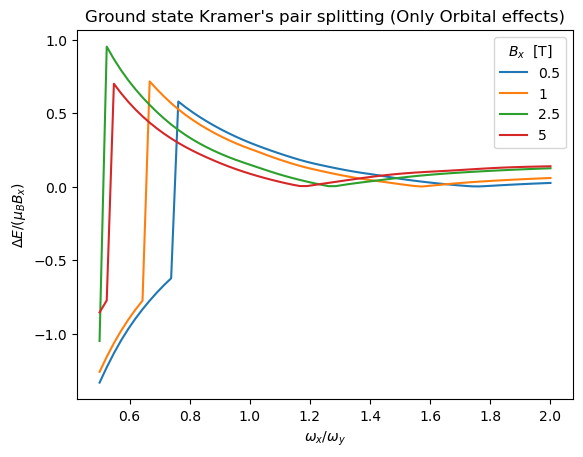

In [72]:
delta_E = np.array([g[0] for g in gaps]).reshape(4,64)#*nqcpfem.UNIT_CONVENTION['J to eV']*1000
x_up = np.sign(angular_momenta[:,0]).reshape(4,64).T
x_up_points = 
plt.scatter(Lx_values/Ly,delta_E.T/(nqcpfem._mu_B*2*np.array(B_values)),label=B_values)
plt.legend(title=r'$B_x $  [T]')
plt.xlabel(r'$\omega_x / \omega_y$')
plt.ylabel(r'$\Delta E / (\mu_B B_x)$')
plt.title("Ground state Kramer's pair splitting (Only Orbital effects)")

In [52]:
bm.add_zeeman_term() # 
bm.post_processed_array().subs('\hbar','hbar')

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

INFO:aiohttp.access:127.0.0.1 [15/Aug/2023:06:01:16 +0000] "GET /__trame_vuetify/trame-vuetify.css HTTP/1.1" 200 239 "http://localhost:39577/index.html?ui=P_0x7f6212cfe050_4&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"


⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [53]:

from nqcpfem.functions import SymbolicFunction
def A_eval_func(lx,Bx):
    # update omega_x
    omega_x_val = bm.constants[sympy.symbols('\hbar')]/(2*bm.parameter_dict[sympy.symbols('m')]*(lx/10)**2)
    bm.parameter_dict[omega_x] = omega_x_val
    
    # update A-field
    A_field_vals = make_vector_field([Bx,0,0],bm.position_symbols)
    bm.function_dict.update({asym:SymbolicFunction(aval,asym) for asym,aval in zip(A_field_sym,A_field_vals)})
    
    return solver.solve(A_model)

A_app_save = 'A_real_fem.save'

Lx_values = np.linspace(50e-9,200e-9,64)
B_values = [0.5,1,2.5,5]
from nqcpfem.parameter_search import GridSearch

A_app_search  = None 
if os.path.exists(A_app_save):
    try:
        A_app_search  = GridSearch.load(A_app_save)
    except Exception as err:
        print(err)

if A_app_search  is None:
    A_app_search  = GridSearch({'lx':Lx_values,'Bx':B_values},evaluation_function=A_eval_func,save_file=A_app_save)




INFO:aiohttp.access:127.0.0.1 [15/Aug/2023:06:01:16 +0000] "GET /__trame_vtk/trame-vtk.js HTTP/1.1" 200 255 "http://localhost:39577/index.html?ui=P_0x7f6212cfe050_4&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"


In [54]:
A_app_search.run(True,False)

INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [589.7492211579068, 18768.387843852335, 18018.03996716306, 23145.6564900623, 23688.367657941984]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 589.7492211579068
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [582.4649300828162, 18782.861408049663, 18042.910405369556, 23185.74583000821]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 582.4649300828162
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [575.5809612042118, 18655.188497226856, 18201.890856102098, 23224.41118399368]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 575.5809612042118
INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [569.071

Text(0.5, 1.0, "Ground state Kramer's pair splitting (With Zeeman Term)")

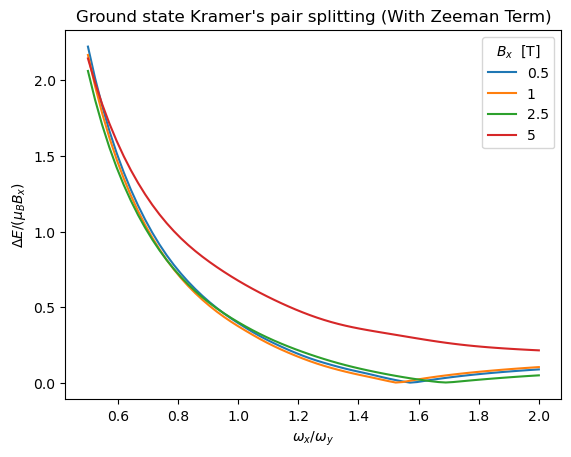

INFO:root:client cbadf92f3398403a9b549fabf66a0693 disconnected
INFO:root:No more connections, scheduling shutdown
INFO:aiohttp.access:127.0.0.1 [15/Aug/2023:06:01:16 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"
INFO:root:client 3e27e6711bf34ad5820ddb83fee8dcef connected


In [57]:

AB_gaps = [find_spin_gap(r,A_model) for r in A_app_search.results]
delta_E = np.array([g[0] for g in AB_gaps]).reshape(4,64)#*nqcpfem.UNIT_CONVENTION['J to eV']*1000
plt.plot(Lx_values/Ly,delta_E.T/(nqcpfem._mu_B*2*np.array(B_values)),label=B_values)
plt.legend(title=r'$B_x $  [T]')
plt.xlabel(r'$\omega_x / \omega_y$')
plt.ylabel(r'$\Delta E / (\mu_B B_x)$')
plt.title("Ground state Kramer's pair splitting (With Zeeman Term)")

# Effects of Strain on G-matrix
TODO